**Authors:** Salo Elia & Nadav Shaoulian  
**Date:** June-July 2021

### **Overview**
Apples are one of the most important temperate fruit crops in the world. Foliar (leaf) diseases pose a major threat to the overall productivity and quality of apple orchards. The current process for disease diagnosis in apple orchards is based on manual scouting by humans, which is time-consuming and expensive.

Although computer vision-based models have shown promise for plant disease identification, there are some limitations that need to be addressed. Large variations in visual symptoms of a single disease across different apple cultivars, or new varieties that originated under cultivation, are major challenges for computer vision-based disease identification. These variations arise from differences in natural and image capturing environments, for example, leaf color and leaf morphology, the age of infected tissues, non-uniform image background, and different light illumination during imaging etc.  

### **Objectives** 
On this notebook we will try to develop machine learning-based models to accurately classify a given leaf image from the test dataset to a particular disease category, and to identify an individual disease from multiple disease symptoms on a single leaf image.    

We will be using the tools that we learned from the 'Introduction to Computer Vision' Course we did in Afeka College.

### **Plan and Goals** 
*   Data Analysis
*   Data pre processing
*   Using Different Augmentations
*   Using Different Optimizers
*   Testing Scores with Different Pre-trained Neural Networks
*   Finding the ideal Hyper-parameters on each Neural Network tested
*   Meassure results with Different Classification Metrics 
 



Let`s Start!











The dataset is not the original competition 1000X1000 sized dataset. It is a resized dataset , included multiple resized version of the dataset. There are four different sizes of the dataset: 256, 384, 512, 640.  
First, we will start to build and train models using the 256 sized photos and afterwards we will consider to move to the larger ones.

# Data Analysis

Let`s start analyzing our data using the Pandas library.

In [1]:
import pandas as pd

### Train data CSV Reading:

In [3]:
train_df = pd.read_csv("/content/train (2).csv")
train_df

image                           labels
0      800113bb65efe69e.jpg                          healthy
1      8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2      80070f7fb5e2ccaa.jpg                             scab
3      80077517781fb94f.jpg                             scab
4      800cbf0ff87721f8.jpg                          complex
...                     ...                              ...
18627  fffb900a92289a33.jpg                          healthy
18628  fffc488fa4c0e80c.jpg                             scab
18629  fffc94e092a59086.jpg                             rust
18630  fffe105cf6808292.jpg          scab frog_eye_leaf_spot
18631  fffe472a0001bd25.jpg                          healthy

[18632 rows x 2 columns]

### Null and Missing values check:

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18632 entries, 0 to 18631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18632 non-null  object
 1   labels  18632 non-null  object
dtypes: object(2)
memory usage: 291.2+ KB


There are no label missing values in the dataset.

### Unique Label values (number of catagories):

In [5]:
train_df['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

We have 6 label catagories in our dataset. 

### Data histogram and Distribution

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



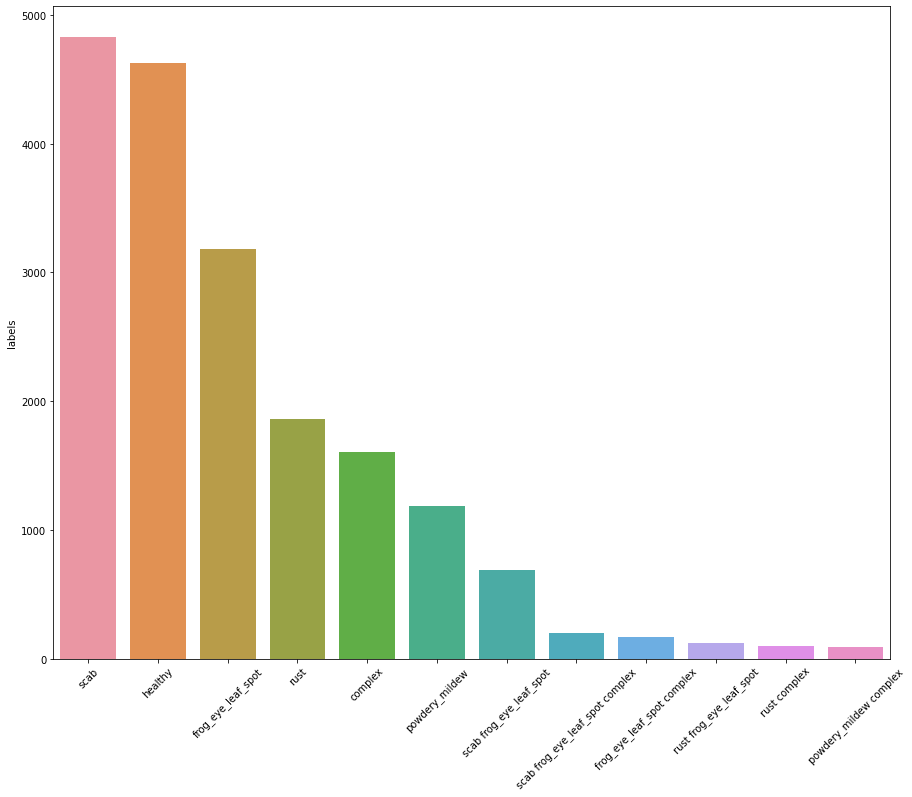

In [7]:
plt.figure(figsize=(15,12))
labels_hist = sns.barplot(train_df.labels.value_counts().index,train_df.labels.value_counts())
for item in labels_hist.get_xticklabels():
    item.set_rotation(45)

In [8]:
fig = go.Figure(data=[go.Pie(labels=train_df['labels'].value_counts().index,values=train_df['labels'].value_counts().values)])
fig.update_layout(title='Label distribution')
fig.show()

### Plant Categories Visualisation

In [ ]:
train_image_path = "../input/resized-plant2021/img_sz_256"

Image Display Method

In [ ]:
def display_images(train_path,labels,rows,cols):
  fig = plt.figure(figsize=(20, 40))
  idx = 1

  for i in range(rows):
    df = list(train_df.loc[train_df['labels'] == labels[i]]['image'])
    for j in range(cols):
      img_path = df[j]
      img = cv2.imread(os.path.join(train_path,img_path))
      image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.subplot(rows,cols,idx)
      plt.imshow(image)
      plt.title("Class:" + str(labels[i]) + ",Image:"+ str(j+1))
      idx += 1


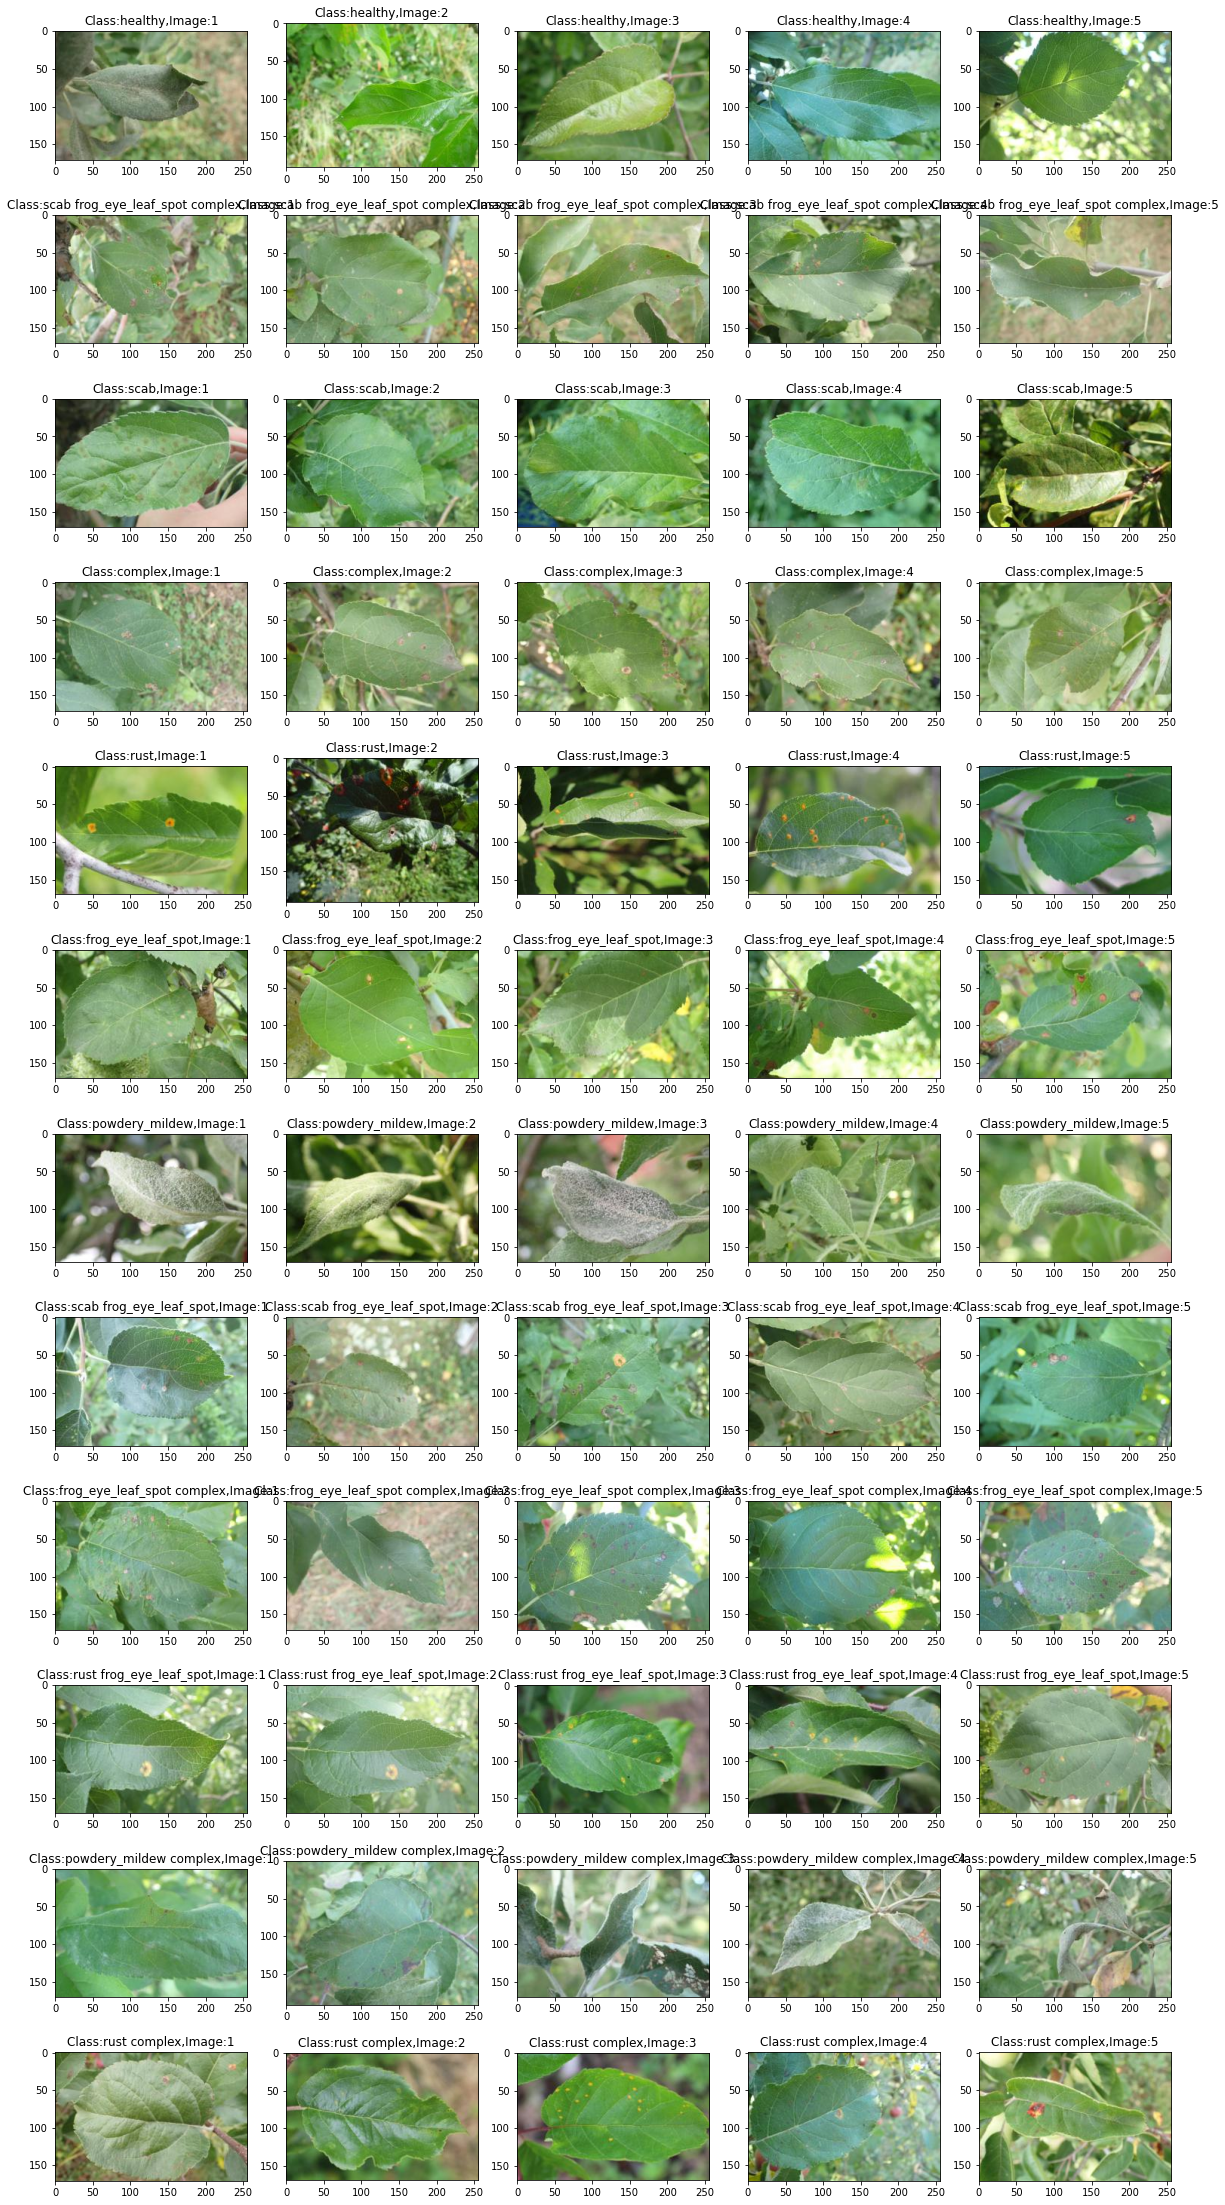

In [ ]:
labels_arr = train_df['labels'].unique()
display_images(train_image_path,labels_arr,12,5)

## Conclusions from the Data Analysis
We can see that some of the leaves may have couple of diseases. It means that the models output will be a vector that contains 1s and 0s , depending on the leaf diseases respectively. Therefore , we will need to encode the data frame in accordance.  

# Data Pre-Processing

The Data Pre-process includes:

*   The Plant Dataset Class
*   Data Train and Validation Split
*   Focal Loss Class
*   Train and Validation methods
*   Model Save/Load methods
*   Plot Graphs Method
*   Data frame Encoding
*   Test and Submission methods
















### Imports and Installations

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch_optimizer as optimizer
import torch.optim as optim

### Folder path setting

In [ ]:
folder_path_256 = "../input/resized-plant2021/img_sz_256"
data_paths_256 = os.listdir(folder_path_256)

### Data Frame Encoding


In [ ]:
train_df_cp = train_df.copy()

In [ ]:
train_df_cp['label_list'] = train_df_cp['labels'].str.split(' ')

In [ ]:
def lbl_lgc(col,lbl_list):
    if col in lbl_list:
        res = 1 
    else:
        res = 0
    return res

In [ ]:
lbls = ['healthy','complex','rust','frog_eye_leaf_spot','powdery_mildew','scab']
for x in lbls:
    train_df_cp[x]=0


for x in lbls:
    train_df_cp[x] = np.vectorize(lbl_lgc)(x,train_df_cp['label_list'])

In [ ]:
train_df_cp.head()

image                           labels  \
0  800113bb65efe69e.jpg                          healthy   
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex   
2  80070f7fb5e2ccaa.jpg                             scab   
3  80077517781fb94f.jpg                             scab   
4  800cbf0ff87721f8.jpg                          complex   

                            label_list  healthy  complex  rust  \
0                            [healthy]        1        0     0   
1  [scab, frog_eye_leaf_spot, complex]        0        1     0   
2                               [scab]        0        0     0   
3                               [scab]        0        0     0   
4                            [complex]        0        1     0   

   frog_eye_leaf_spot  powdery_mildew  scab  
0                   0               0     0  
1                   1               0     1  
2                   0               0     1  
3                   0               0     1  
4                   0               0     0

### The Train-Validation split

In [ ]:
train_path , val_path = train_test_split(data_paths_256, test_size =0.2 , random_state= 2021)

**Note:** The ideal train-validation split is by using Cross Validation methods like K-Fold for example , but it may take us some time to use them. For now, we will split the Data into 80% Train and 20% Validation. Later on, related the time left, we will consider in using some split Cross validation methods like the K-Fold.

### The Plant Dataset Class

In [ ]:
class Plant_Dataset(Dataset):
  def __init__(self,folder_path,data_paths,data_df=train_df_cp,size=224,transforms=None, train=True):
    self.folder_path = folder_path
    self.data_paths = data_paths
    self.data_df = data_df
    self.transforms = transforms
    self.train = train
    self.size = size

  def __getitem__(self, idx):
    img_path = os.path.join(self.folder_path,self.data_paths[idx])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (self.size, self.size), interpolation=cv2.INTER_AREA)
    image = np.asarray(image)

    if self.train: #for train or validation data
     #label = self.data_df.loc[self.data_df['image']==self.data_paths[idx]].values[0][1]
      j = 0
      vector = [0]*6
      values = self.data_df.loc[self.data_df['image']==self.data_paths[idx]].values
      for i in range(3,9):
        num = values[0][i]
        vector[j] = num
        j = j+1
     
      vector=np.asarray(vector)
      
    
    if self.transforms:
       image = self.transforms(image=image)['image']

    if self.train:
     return image,vector #train or validation data
    else:
      return image,self.data_paths[idx] #test data


  def __len__(self):
    return len(self.data_paths)  



### Focal Loss Class

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.2, gamma=2, logist=False, reduce='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # the scalar factor between 0 and 1 
        self.gamma = gamma # focusing parameter(always positive) that reduces the relative loss for well-classified examples and puts more focus on hard misclassified examples
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        #self.logist = logist # log probabilities 
        self.reduce = reduce # Specifies the reduction to apply to the output - none/mean/sum. ‘none’: no reduction will be applied, ‘mean’: the sum of the output will be divided by the number of elements in the output, ‘sum’: the output will be summed.

    def forward(self, inputs, targets):
        BCE_loss = self.cross_entropy_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

## Train and Validation Methods

In [ ]:
from tqdm.auto import tqdm

### Train Validation General Method

In [ ]:
def train_val(model,loader_train,loader_val,opt,criterion,epoch):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  for e in range(epoch):
    loss_t, acc_t = train(e,model,loader_train,opt,criterion)
    train_loss.append(loss_t)
    train_acc.append(acc_t)
    loss_v , acc_v = validation(e, model, loader_val)
    val_loss.append(loss_v)
    val_acc.append(acc_v)
     
    gc.collect()
    
    torch.cuda.empty_cache()

  return model,train_loss,train_acc,val_loss,val_acc

### Train Method

In [ ]:
def train(e,model,loader,opt,criterion):
  model.train()
  treshold = 0.5
  acc_loss = 0 
  correct = 0
  target_sum = 0
 # tqdm_loader = tqdm(loader)
  for i, (img, target) in enumerate(loader):
    
    img = img.float()
   # img = img.permute(0,3,1,2).float()
    target = target.float()
    img = img.cuda()
    target = target.cuda()
    
    opt.zero_grad()
    output = torch.sigmoid(model(img)).float()
    loss = criterion(output, target)
    loss.backward()
    opt.step()
    
    acc_loss += loss.item()
    avg_loss = acc_loss/(i+1)
    
    output = torch.where(output > treshold, 1,0)
    
    #correct += output.eq(target.view_as(output)).sum().item()/(6*len(target))
    
    res = output==target
    
    for tensor in res:
        if False in tensor:
            continue
        else:
            correct += 1
    
    target_sum += len(target)
    avg_acc = correct/((target_sum))
    
    #tqdm_loader.set_description("Epoch {}, train_loss={:4} , acc={:4}".format(e,round(avg_loss,4), round(avg_acc ,4)))
    
    del img
    del target
    del output
    del loss
    del res
    
    gc.collect() 
    torch.cuda.empty_cache()
  
  del acc_loss
  
  del target_sum
  del correct

    
  return avg_loss, avg_acc




### Validation Method

In [ ]:
def validation(e, model, loader):
  model.eval()
  #tqdm_loader = tqdm(loader_val)
  treshold = 0.5
  acc_loss = 0
  correct =0
  target_sum=0
  for i, (img,target) in enumerate(loader):
    img = img.float()
 #   img = img.permute(0,3,1,2).float()
    target = target.float()

    img = img.cuda()
    target = target.cuda()

    with torch.no_grad():
      output = torch.sigmoid(model(img)).float()
      loss = criterion(output, target)
        
    acc_loss += loss.item()
    avg_loss = acc_loss/(i+1)
    
    output = torch.where(output > treshold, 1,0)
    
   # correct += output.eq(target.view_as(output)).sum().item()/(6*len(target))
    res = output==target
    
    for tensor in res:
        if False in tensor:
            continue
        else:
            correct += 1
    
    
    target_sum += len(target)
    avg_acc = correct/((target_sum))
    
    
   # tqdm_loader.set_description("Epoch {}, val_loss={:4} , val_acc={:4}".format(e,round(avg_loss,4), round(avg_acc ,4)))
    
    del img
    del target
    del output
    del res
    
    
    gc.collect() 
    torch.cuda.empty_cache()
  

  del target_sum
  del acc_loss
  del correct

    
  return avg_loss, avg_acc


### Test Mehtod

In [ ]:
def model_test(model,test_loader):
 model.eval()
 images = []
 predictions = []   
 treshold = 0.5
 for i ,(img,img_name) in enumerate(test_loader):
    images.append(img_name)
    img = img.float()
    img = img.cuda()
    
    with torch.no_grad():
      output = torch.sigmoid(model(img)).float()
    
    output = torch.where(output > treshold, 1,0)
    predictions.append(output)
    
    del img
    del output
    
    gc.collect() 
    torch.cuda.empty_cache()
    
    
 return images,predictions

### Submission method

In [ ]:
def submission(images,predictions):
  str_preds = []
  img_names = []
  j=0  
  for vec in predictions:
    labels = []
    for i in range(len(vec[0])):
      if vec[0][i]==1:
       labels.append(lbls[i])
         
    l = ' '.join(labels)
    str_preds.append(l) 
    img_names.append(images[j][0])
    j += 1
    
  output = pd.DataFrame({'image': img_names, 'labels': str_preds})
  output.to_csv('submission.csv',index=False)             
            
    

### Model Save method

In [ ]:
def save_model(model,optimizer,epoch,train_loss,val_loss,train_acc,val_acc,path):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc
            }, path)

### Model Load method

In [ ]:
def load_model(path,model,optimizer):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  train_loss = checkpoint['train_loss']
  val_loss = checkpoint['val_loss']
  train_acc = checkpoint['train_acc']
  val_acc = checkpoint['val_acc']
  return train_loss,val_loss,train_acc,val_acc,epoch

### Plot Graphs Method

In [ ]:
def plot_graphs(train_loss,val_loss,train_acc,val_acc,epcohs):
  plt.figure(figsize=(30,10))

  plt.subplot(1,2,1)
  plt.title("Loss")
  plt.plot(list(range(0,epcohs)),train_loss, label='Train')
  plt.plot(list(range(0,epcohs)), val_loss, label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Rate')
  plt.legend()
    
  plt.subplot(1,2,2)
  plt.title("Accuracy")
  plt.plot(list(range(0,epcohs)),train_acc, label='Train')
  plt.plot(list(range(0,epcohs)), val_acc, label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Rate')
  plt.legend()
  

# Models and Tests

Due to the competition and submission rules,and in order to reduce problems and time wasting, we decided to split our code into two notebooks:  

1.   The main notebook: includes the data analysis,pre processing and training/evalutaion of the models. 
2.   The Kaggle submission notebook: the notebook wich we will submit to the kaggle competition.




  
The first model will be relatively simple. The models development and complexity will be gradual and we will use more complex tools from submission to submission. 

### Imports

In [ ]:
import torchvision.models as models
#!pip install albumentations==0.4.6
#!pip install -U git+https://github.com/albu/albumentations > /dev/null
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms as T
import gc 

In [ ]:
gc.collect() 
torch.cuda.empty_cache()

# 1st Model



*   **Architecture**: Resnext50 (Not Pre-Trained)
*   **Transforms**: Normalize
*   **Batch Size**: 25
*   **Epochs** : 20
*   **Learning Rate**: 0.0001
*   **Learning Rate Scheduler**: None










In [ ]:
BS = 25
EPOCHS = 20
transforms = A.Compose([A.Normalize(),ToTensorV2()])

### Train and Validation Data Loading using Dataloader

In [ ]:
train_data = Plant_Dataset(folder_path_256,train_path,transforms=transforms,train=True)
loader_train = DataLoader(train_data, batch_size=BS, shuffle=True,num_workers=4)
val_data = Plant_Dataset(folder_path_256,val_path,transforms=transforms,train=True) 
loader_val = DataLoader(val_data,batch_size=BS, shuffle=False,num_workers=4)

In [ ]:
model = models.resnext50_32x4d(pretrained=False)

in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features,6)

In [ ]:
model.cuda()
criterion = torch.nn.BCELoss()
criterion.cuda()
optimi = optim.Adam(model.parameters(), lr=1e-4)

### Model Training and Validation

In [ ]:
model,train_loss,train_acc,val_loss,val_acc = train_val(model,loader_train,loader_val,optimi,criterion,EPOCHS)

### Train/Validation Loss and Accuracy Graphs

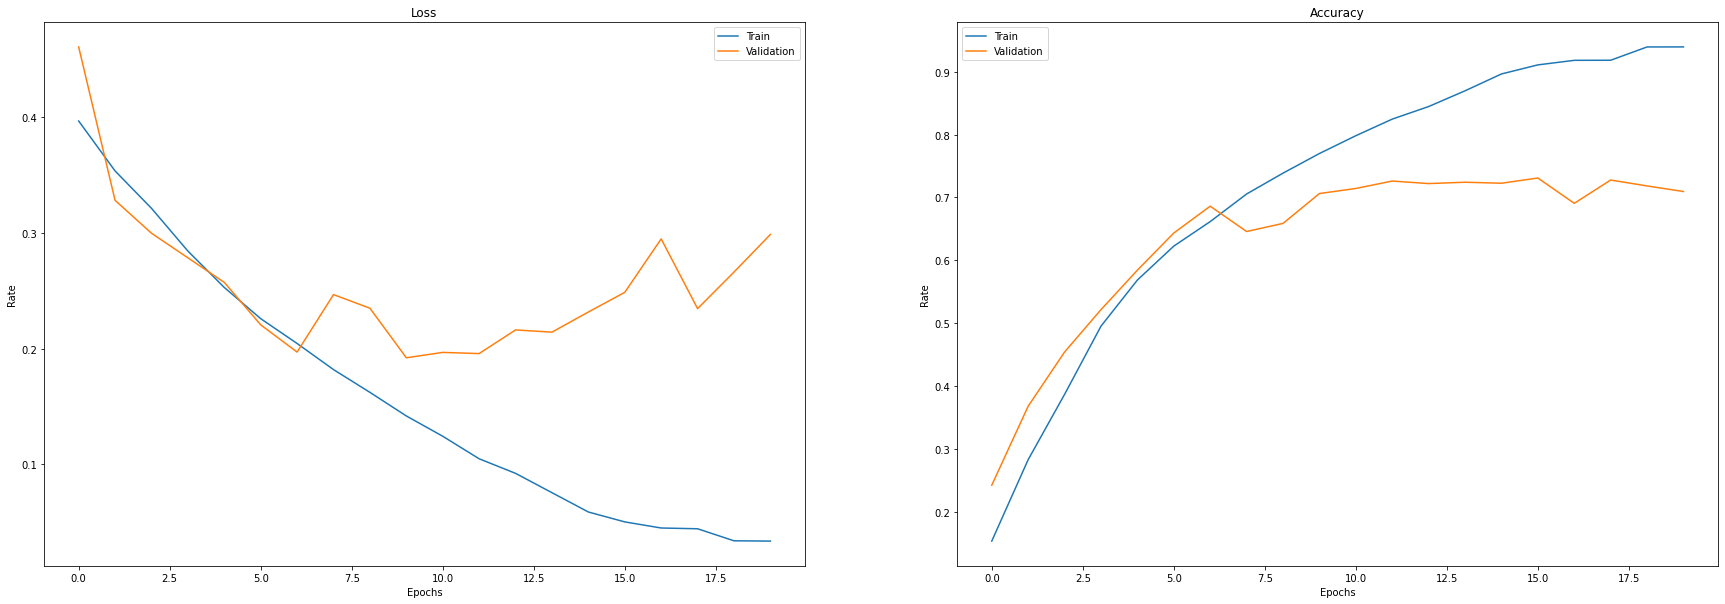

In [ ]:
plot_graphs(train_loss,val_loss,train_acc,val_acc,EPOCHS)

## Model Test and Submission

In [ ]:
test_path = "../input/plant-pathology-2021-fgvc8/test_images"
test_data_paths = os.listdir(test_path)

In [ ]:
gc.collect() 
torch.cuda.empty_cache()

In [ ]:
test_data = Plant_Dataset(test_path,test_data_paths,transforms=transforms,train=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False,num_workers=0)

In [ ]:
images,predictions = model_test(model,test_loader)
submission(images,predictions)

##1st Model score : **0.61272**

#2nd Model

In this model we will use couple of **augmentations** to improve the results and reduce the overfitting we had in the 1st model. We will also increase the batch size to 50 and the number of epochs to 30.  
We will use some augmentations that we learned in the course and more:  

 
*   Rotate
*   Blur
*   HorizontalFlip
*   VerticalFlip
*   GaussNoise
*   IAASharpen
*   MotionBlur
*   RandomBrightnessContrast



It is importnat to choose specific augmentations that won't not cause damage and destroy the data. For example, we chose not using augmentations that relate to RGB colors and channels changing. 




In [ ]:
from albumentations import (
    Rotate, Blur, HorizontalFlip, VerticalFlip, GaussNoise, IAASharpen, MotionBlur,RandomBrightnessContrast 
)

###Augmentation Display

In [ ]:
display_transforms = A.Compose([Rotate(always_apply=True), Blur(always_apply=True), HorizontalFlip(always_apply=True), VerticalFlip(always_apply=True),
                                GaussNoise(always_apply=True), IAASharpen(always_apply=True), MotionBlur(always_apply=True),
                                RandomBrightnessContrast(always_apply=True)])

In [ ]:
display_data = Plant_Dataset(folder_path_256,train_path,transforms=None,train=False)

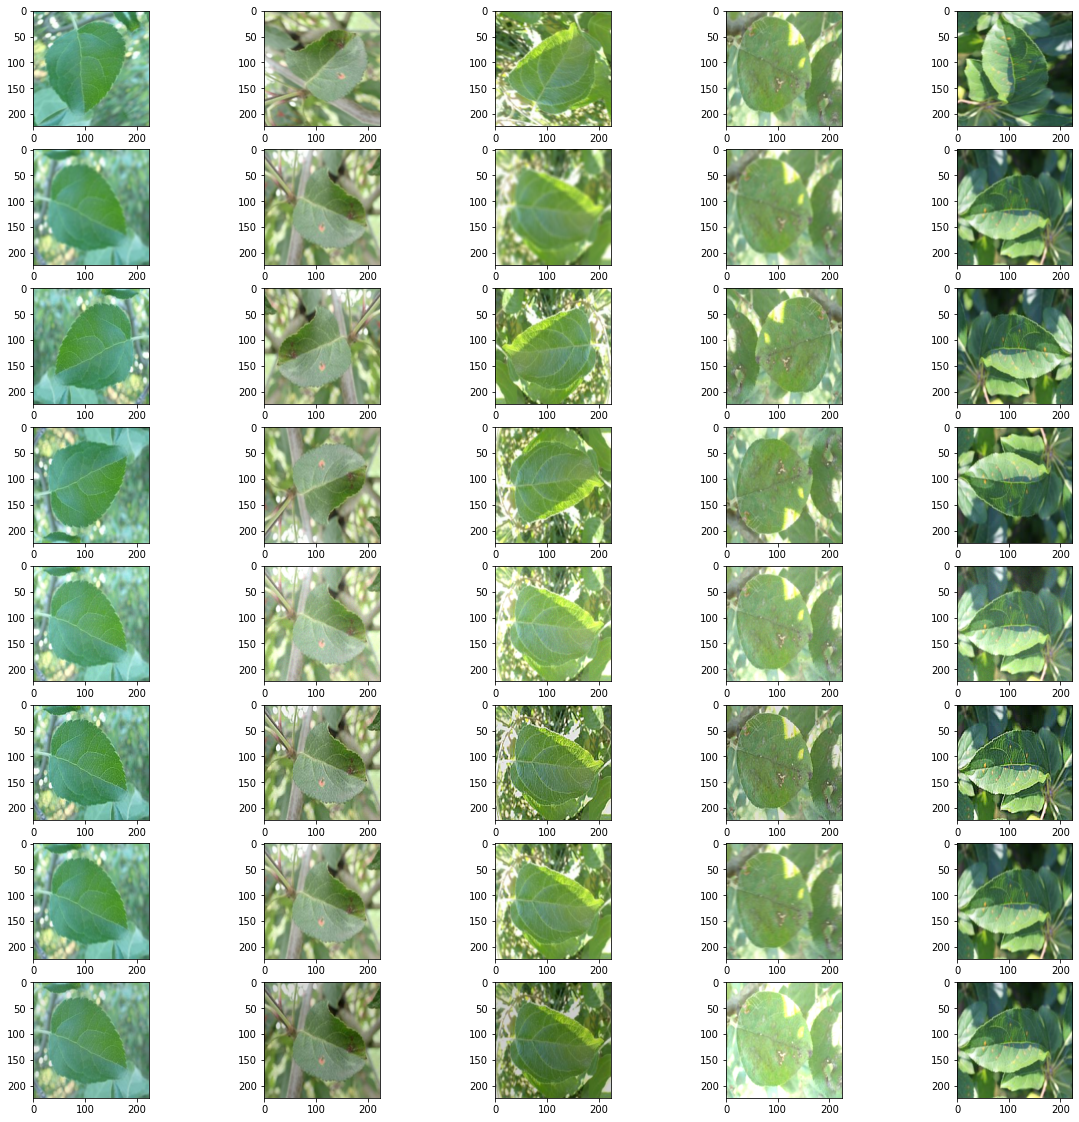

In [ ]:
fig = plt.figure(figsize=(20,20))
idx = 1
for i in range(8):
  for j in range(5):
    img = display_data.__getitem__(j)
    plt.subplot(8,5,idx)
    plt.imshow(display_transforms[i](image=img[0])['image'])
    idx = idx+ 1

In [ ]:
del display_data

###Overview



*   **Architecture**: Resnext50 (Not Pre-Trained)  
*   **Optimizer**: Adam
*   **Transforms**: Blur, HorizontalFlip, VerticalFlip, GaussNoise, IAASharpen, RandomBrightnessContrast, Normalize
*   **Batch Size**: 50
*   **Epochs** : 30
*   **Learning Rate**: 0.0001
*   **Learning Rate Scheduler**: None










##Model and Test settings

In [ ]:
BS = 50
EPOCHS = 30
transforms = A.Compose([Blur(), HorizontalFlip(), VerticalFlip(), GaussNoise(),
                        IAASharpen(),RandomBrightnessContrast(),
                        A.Normalize(),ToTensorV2()])
val_transforms = A.Compose([A.Normalize(),ToTensorV2()])

In [ ]:
train_data = Plant_Dataset(folder_path_256,train_path,transforms=transforms,train=True)
loader_train = DataLoader(train_data, batch_size=BS, shuffle=True,num_workers=4)
val_data = Plant_Dataset(folder_path_256,val_path,transforms=val_transforms,train=True) 
loader_val = DataLoader(val_data,batch_size=BS, shuffle=False,num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = models.resnext50_32x4d(pretrained=False)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features,6)

In [ ]:
model.cuda()
criterion = torch.nn.BCELoss()
criterion.cuda()
optimi = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
model,train_loss,train_acc,val_loss,val_acc = train_val(model,loader_train,loader_val,optimi,criterion,EPOCHS,23,model_2_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##Train/Validation Loss and Accuracy Graphs

In [ ]:
train_loss,val_loss,train_acc,val_acc,epoch = load_model('/content/drive/MyDrive/ComputerVision1/PlantPathalogy/resnext50_2_final.pth',
                                                   model,optimi)

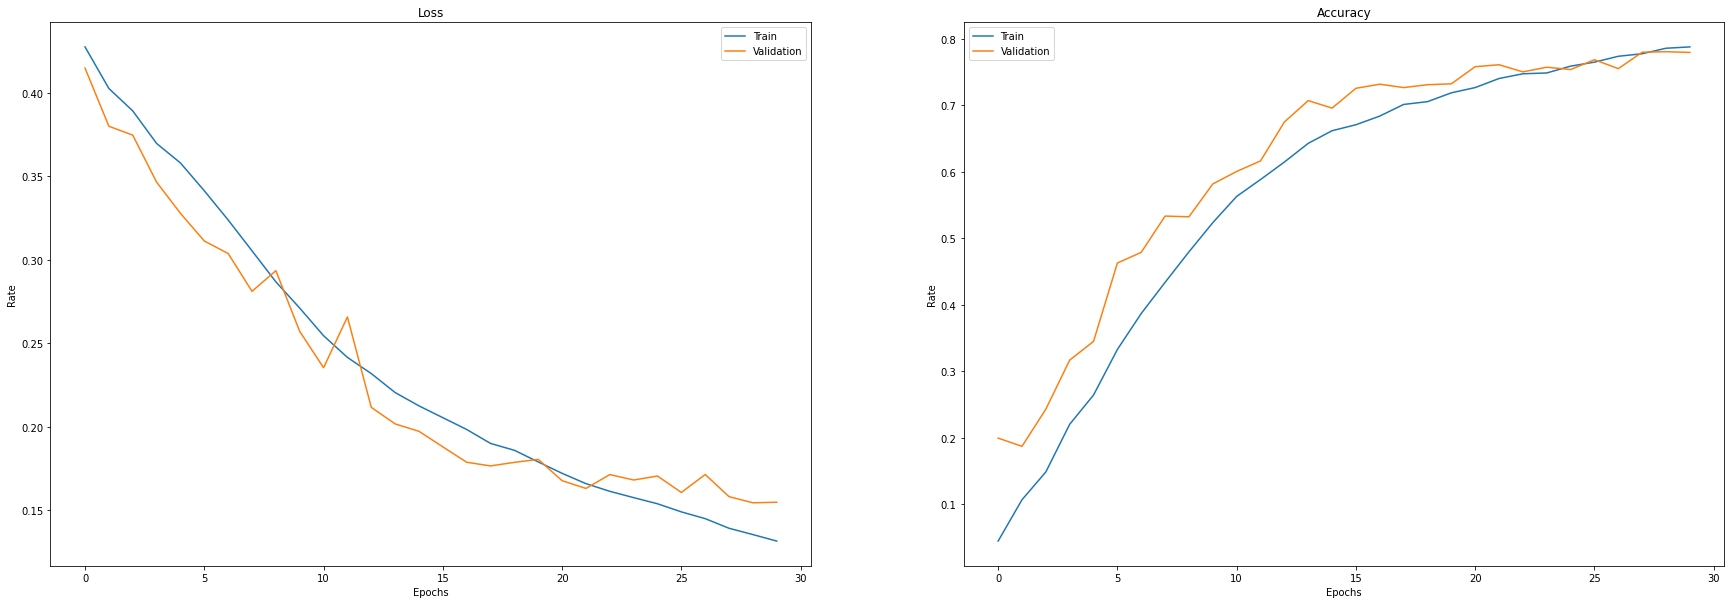

In [ ]:
plot_graphs(train_loss,val_loss,train_acc,val_acc,EPOCHS)

###Test score: **0.66662**

#3rd Model

###Overview



*   **Architecture**: Resnext50 (Pre-Trained)  
*   **Optimizer**: AdamW
*   **Transforms**: Blur, HorizontalFlip, VerticalFlip, GaussNoise, IAASharpen, RandomBrightnessContrast, Normalize
*   **Batch Size**: 50
*   **Epochs** : 20
*   **Learning Rate**: 0.0001
*   **Learning Rate Scheduler**: None










##Model and Test settings

In [ ]:
BS = 50
EPOCHS = 20
transforms = A.Compose([Blur(), HorizontalFlip(), VerticalFlip(), GaussNoise(),
                        IAASharpen(),RandomBrightnessContrast(),
                        A.Normalize(),ToTensorV2()])
val_transforms = A.Compose([A.Normalize(),ToTensorV2()])

In [ ]:
train_data = Plant_Dataset(folder_path_256,train_path,transforms=transforms,train=True)
loader_train = DataLoader(train_data, batch_size=BS, shuffle=True,num_workers=4)
val_data = Plant_Dataset(folder_path_256,val_path,transforms=val_transforms,train=True) 
loader_val = DataLoader(val_data,batch_size=BS, shuffle=False,num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = models.resnext50_32x4d(pretrained=True)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features,6)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [ ]:
model.cuda()
criterion = torch.nn.BCELoss()
criterion.cuda()
optimi = optim.AdamW(model.parameters(), lr=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimi, step_size=5,gamma=0.1)

In [ ]:
model_3_path = '/content/drive/MyDrive/ComputerVision1/PlantPathalogy/resnext50_3'

In [ ]:
model,train_loss,train_acc,val_loss,val_acc = train_val(model,loader_train,loader_val,optimi,criterion,EPOCHS,0,model_3_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


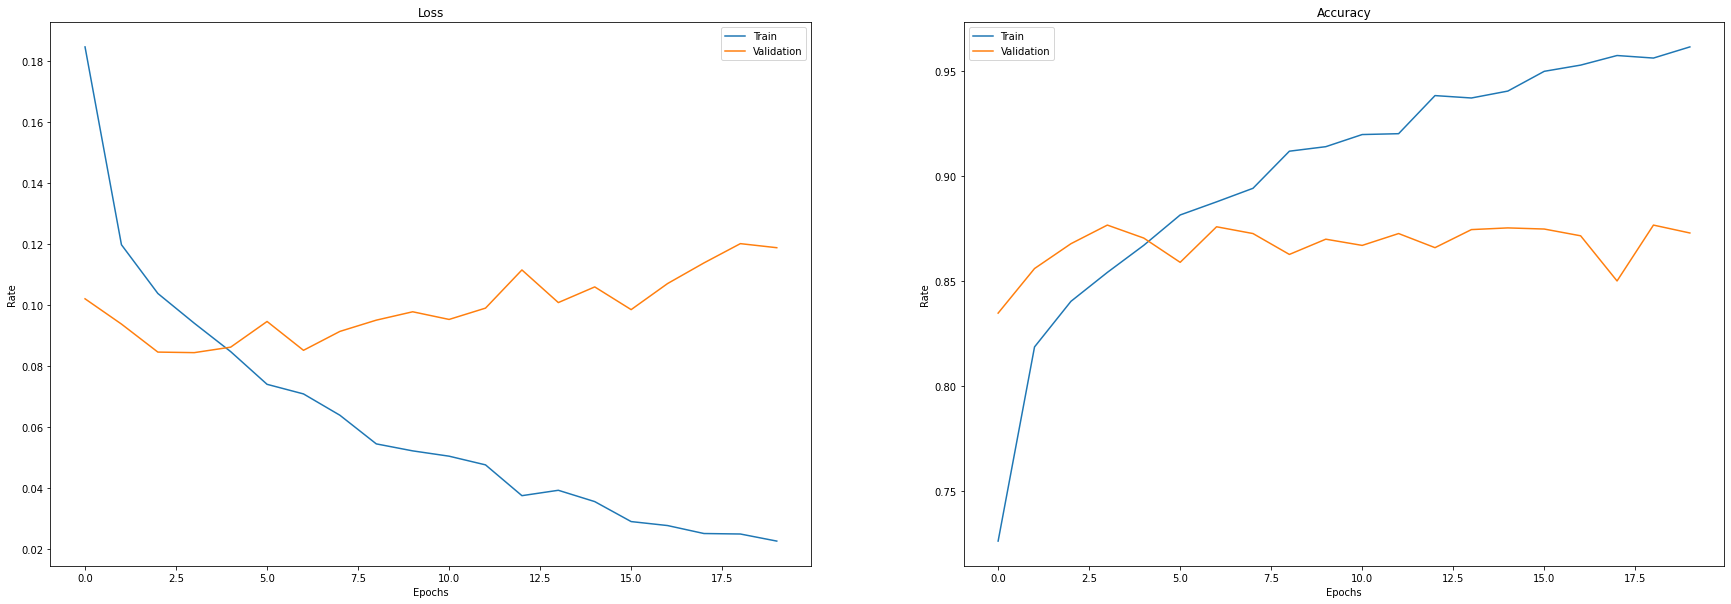

In [ ]:
plot_graphs(train_loss,val_loss,train_acc,val_acc,EPOCHS)

###Test Score : **0.76179**

#4th Model

###Overview



*   **Architecture**: Resnet50 (Pre-Trained)  
*   **Optimizer**: AdamW
*   **Transforms**: Blur,MotionBlur, HorizontalFlip, VerticalFlip, GaussNoise, IAASharpen, RandomBrightnessContrast, Normalize
*   **Batch Size**: 50
*   **Epochs** : 20
*   **Learning Rate**: 0.001
*   **Learning Rate Scheduler**: None










##Model and Test settings

In [ ]:
BS = 50
EPOCHS = 20
transforms = A.Compose([Blur(),MotionBlur(), HorizontalFlip(), VerticalFlip(), GaussNoise(),
                        IAASharpen(),RandomBrightnessContrast(),
                        A.Normalize(),ToTensorV2()])
val_transforms = A.Compose([A.Normalize(),ToTensorV2()])

In [ ]:
train_data = Plant_Dataset(folder_path_256,train_path,transforms=transforms,train=True)
loader_train = DataLoader(train_data, batch_size=BS, shuffle=True,num_workers=4)
val_data = Plant_Dataset(folder_path_256,val_path,transforms=val_transforms,train=True) 
loader_val = DataLoader(val_data,batch_size=BS, shuffle=False,num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = models.resnet50(pretrained=True)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features,6)

In [ ]:
model.cuda()
criterion = torch.nn.BCELoss()
criterion.cuda()
optimi = optim.AdamW(model.parameters(), lr=1e-3)
#scheduler = optim.lr_scheduler.StepLR(optimi, step_size=5,gamma=0.1)

In [ ]:
model_4_path = '/content/drive/MyDrive/ComputerVision1/PlantPathalogy/resnet50'

In [ ]:
model,train_loss,train_acc,val_loss,val_acc = train_val(model,loader_train,loader_val,optimi,criterion,EPOCHS,0,model_3_path)

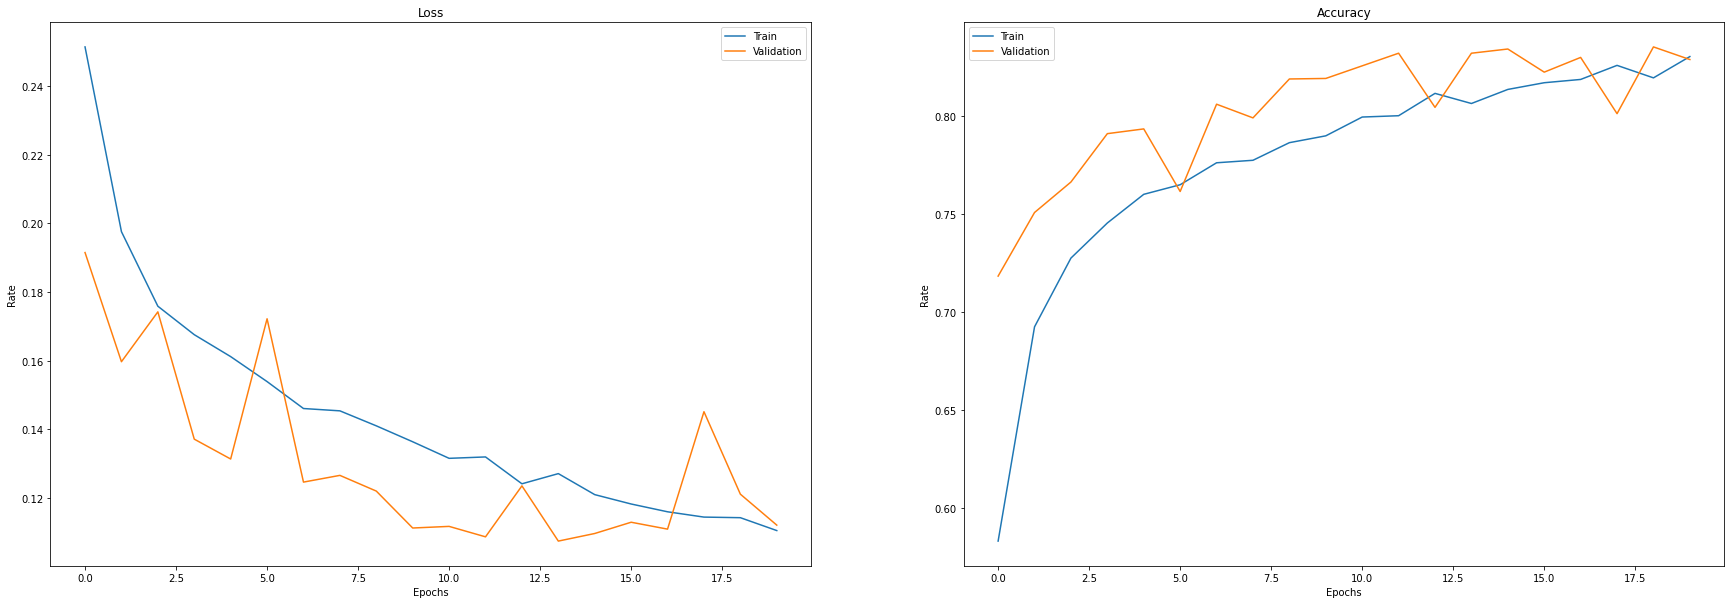

In [ ]:
plot_graphs(train_loss,val_loss,train_acc,val_acc,EPOCHS)

###Test Score : **0.70284**

#5th Model

###Overview



*   **Architecture**: VGG19_BN (Pre-Trained)  
*   **Optimizer**: AdamW
*   **Transforms**: Blur,MotionBlur, HorizontalFlip, VerticalFlip, GaussNoise, IAASharpen, RandomBrightnessContrast, Normalize
*   **Batch Size**: 50
*   **Epochs** : 20
*   **Learning Rate**: 0.0001
*   **Learning Rate Scheduler**: None










##Model and Test settings

In [ ]:
BS = 50
EPOCHS = 20
transforms = A.Compose([Blur(),MotionBlur(), HorizontalFlip(), VerticalFlip(), GaussNoise(),
                        IAASharpen(),RandomBrightnessContrast(),
                        A.Normalize(),ToTensorV2()])
val_transforms = A.Compose([A.Normalize(),ToTensorV2()])

In [ ]:
train_data = Plant_Dataset(folder_path_256,train_path,transforms=transforms,train=True)
loader_train = DataLoader(train_data, batch_size=BS, shuffle=True,num_workers=4)
val_data = Plant_Dataset(folder_path_256,val_path,transforms=val_transforms,train=True) 
loader_val = DataLoader(val_data,batch_size=BS, shuffle=False,num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = models.vgg19_bn(pretrained=True)
model.classifier[6] = nn.Linear(4096,6)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [ ]:
model.cuda()
criterion = torch.nn.BCELoss()
criterion.cuda()
optimi = optim.AdamW(model.parameters(), lr=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimi, step_size=5,gamma=0.1)

In [ ]:
model_5_path = '/content/drive/MyDrive/ComputerVision1/PlantPathalogy/vgg19bn_1'

In [ ]:
model,train_loss,train_acc,val_loss,val_acc = train_val(model,loader_train,loader_val,optimi,criterion,EPOCHS,0,model_5_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


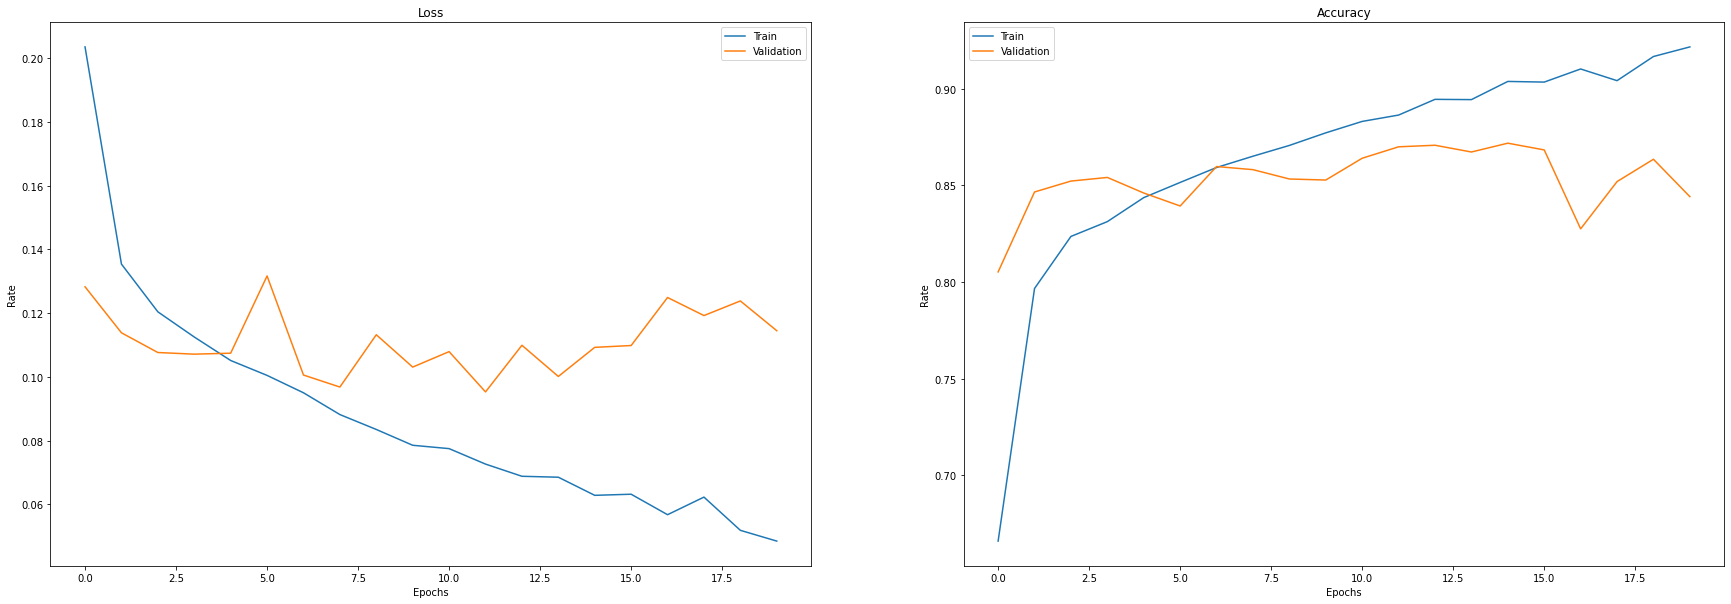

In [ ]:
plot_graphs(train_loss,val_loss,train_acc,val_acc,EPOCHS)

###Test Score : **0.79080**

#Ending and Conclusion

Unfortunately, we will have to stop here this time due to the required work submission time. Given more time we would probably try more different augmentations on different architectures, we would look for ideal parameters for the models by estimating resutls with some Cross validation methods and we would train the models for a longer time. We would also use the Tensor board in some of the models. In any case, this work was important to us because we learned a lot about the Computer Vision world and because we applied the topics we learned in the course during the semester. In total, the results were good and we are mostly satisfied with the progress we made and the obstacles we overcame during the work, regardless of the test scores. That was a great learning. 